# Query Log Analysis

## Functionalities
- Plot number of database queries per second.
- Plot instantaneous latency of database queries.
- Plot latency distribution of database queries.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    *_service*.tar.gz
  ...
  [node-n]/
    *_service*.tar.gz
```
These tarballs contain database query log files named `queries.log`.

## Notebook Configuration

In [1]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-11-23-16-32-52"

########## LATENCY
# Max expected value
MAX_LATENCY_IN_S = 1
# Bin size
LATENCY_BIN_IN_MS = 1

## Notebook Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from parsers.query_parser import QueryParser
from utils.utils import *

## Log Parsing

In [3]:
# Build data frame
query = pd.concat(
        [pd.DataFrame.from_dict(QueryParser(logfile).parse()) for logfile in get_query_logfiles(EXPERIMENT_DIRNAME)],
        ignore_index=True)

In [4]:
# (Re) Build columns
start_time = get_experiment_start_time(EXPERIMENT_DIRNAME)
query["timestamp"] = query.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
query["window"] = query.apply(lambda r: int(r["timestamp"]), axis=1)

In [5]:
# (Re) Create index
query.set_index("timestamp", inplace=True)

In [6]:
# Get values
dbnames = sorted(query["dbname"].unique())
types = sorted(query["type"].unique())

## Number of Queries per Second

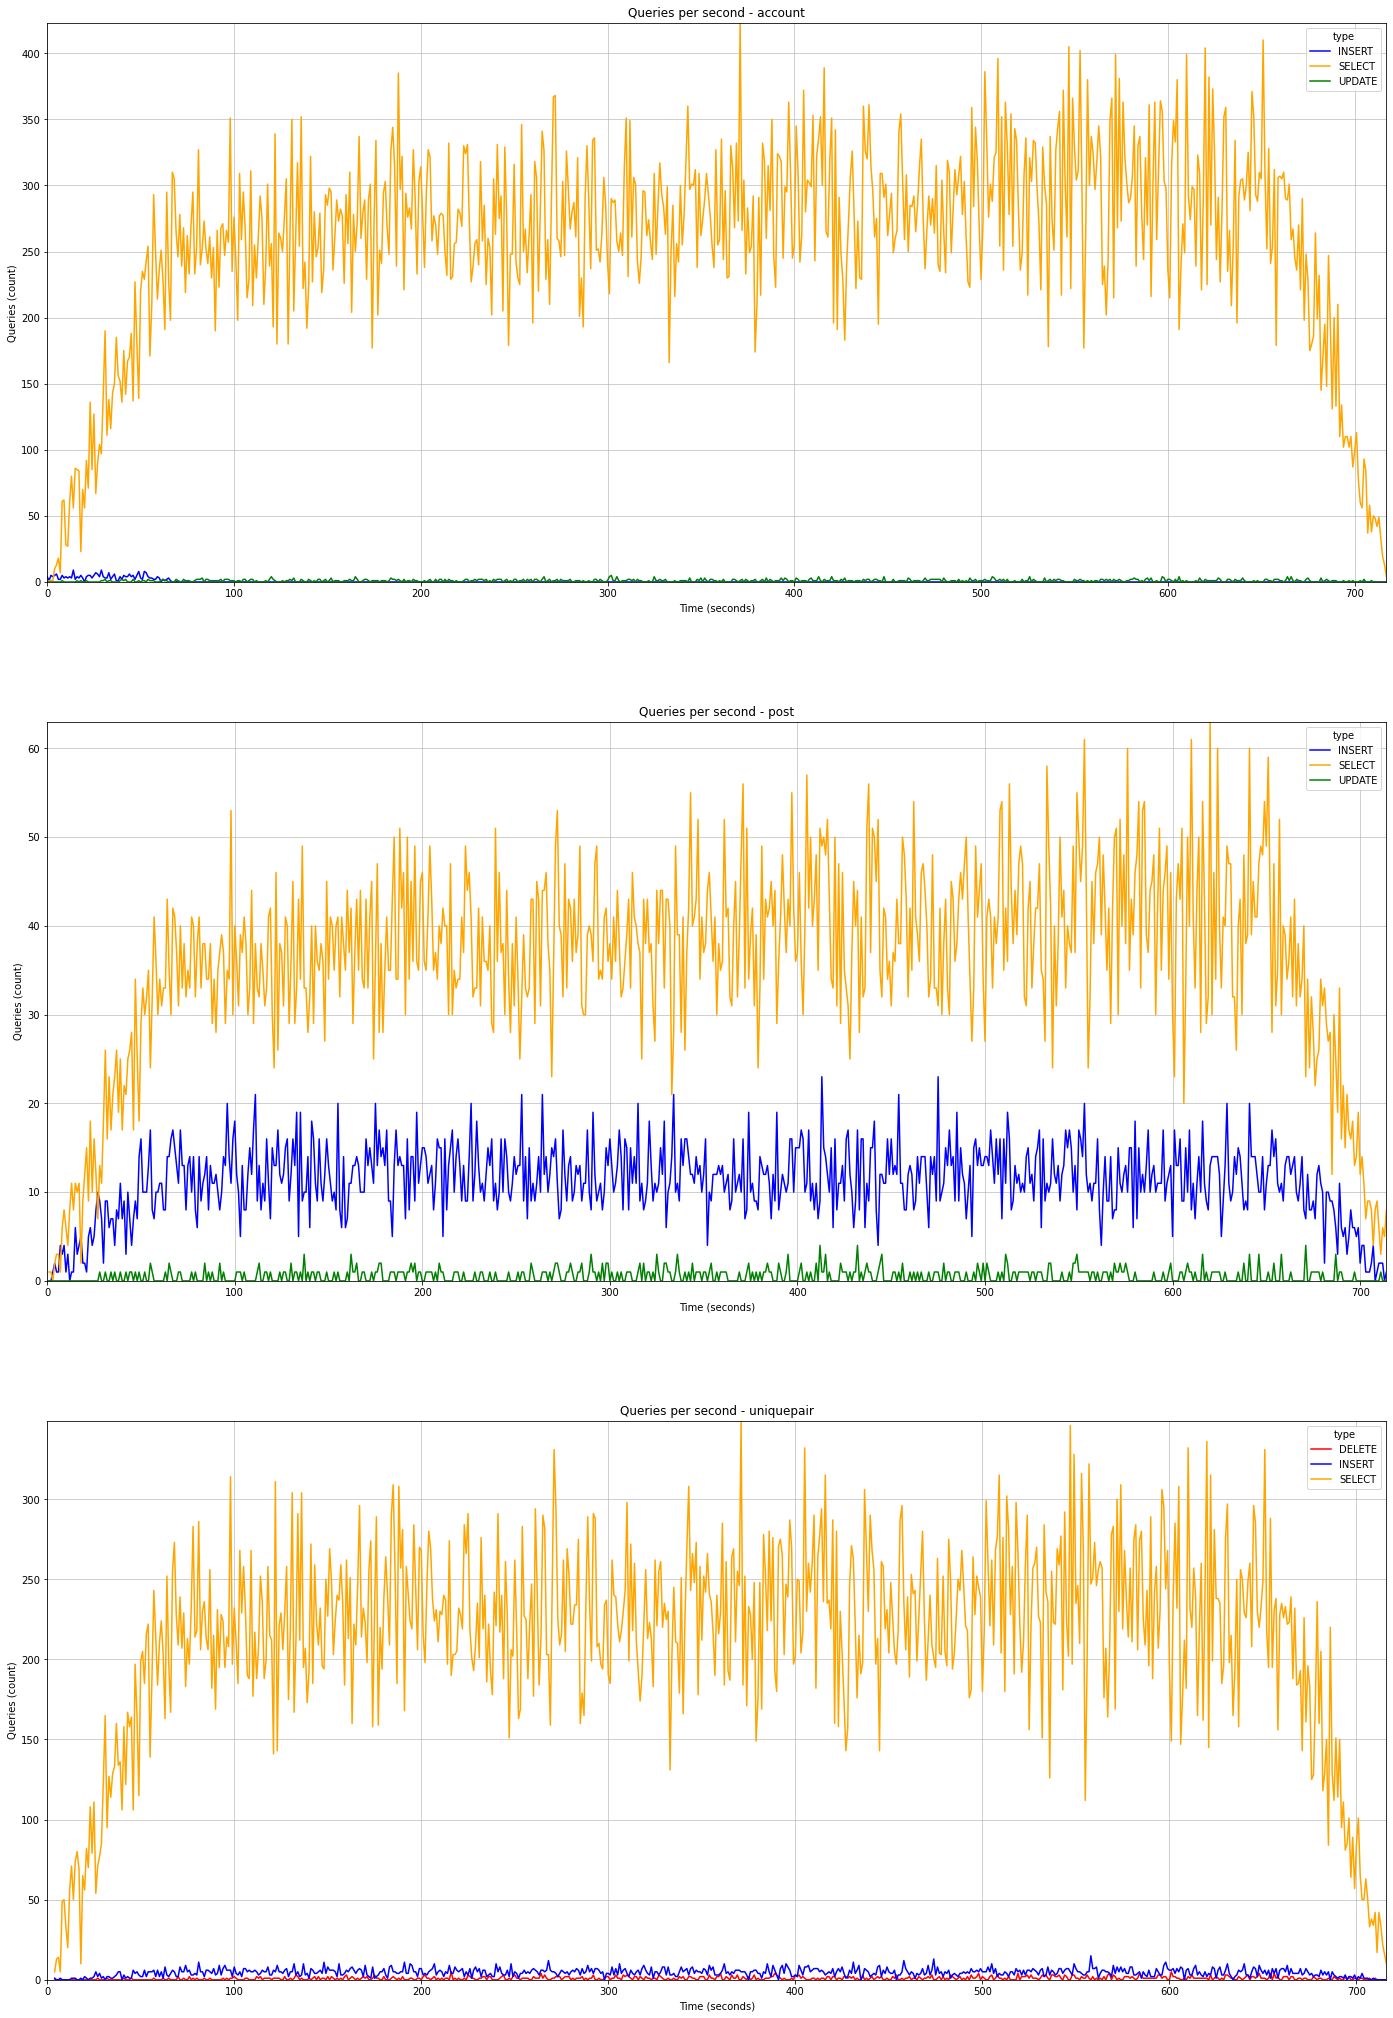

In [7]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot
fig = plt.figure(figsize=(24, len(dbnames) * 12))
for (i, dbname) in enumerate(dbnames):
    df = query[(query["dbname"] == dbname)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    df = df.groupby(["window", "type"])["window"].count().unstack().fillna(0)
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(dbnames), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((MIN_TIME or 0, MAX_TIME or int(df.index.max())))
    ax.set_ylim((0, int(df.values.max())))
    df.plot(ax=ax, kind="line", title="Queries per second - %s" % dbname, xlabel="Time (seconds)",
        ylabel="Queries (count)", color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"},legend=True, grid=True)
    plt.subplots_adjust(hspace=0.25)

## Instantaneous Latency of Queries

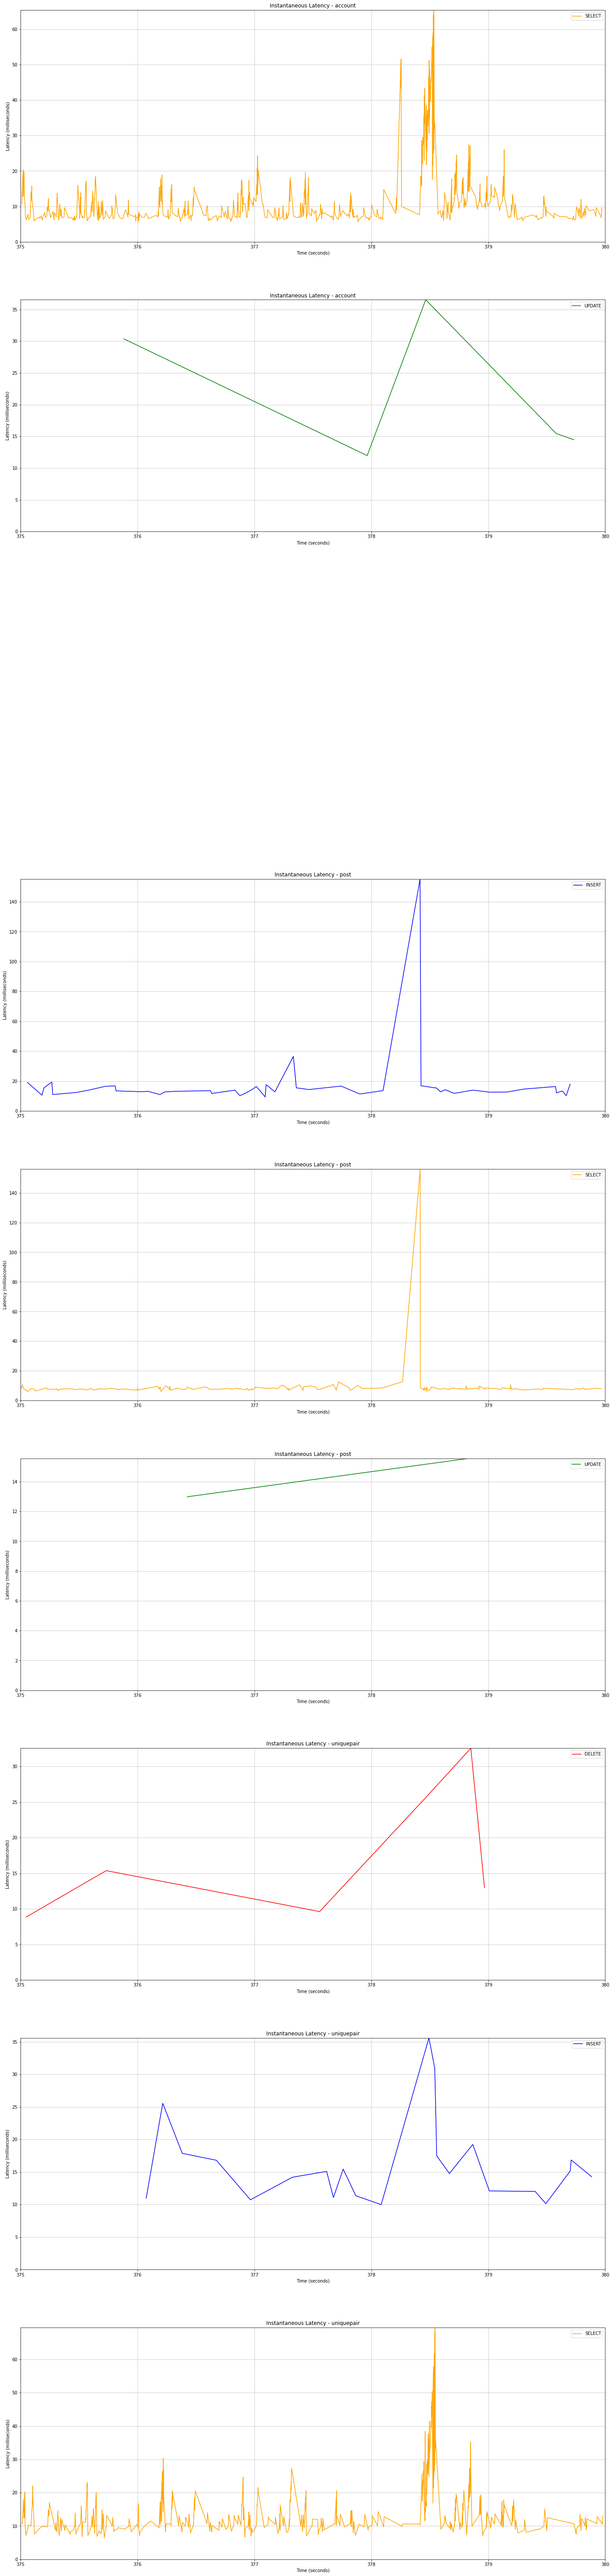

In [11]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = 375
# Maximum time (in seconds)
MAX_TIME = 380

# Plot
fig = plt.figure(figsize=(24, len(dbnames) * len(types) * 12))
for (i, dbname) in enumerate(dbnames):
    for (j, type) in enumerate(types):
        df = query[(query["dbname"] == dbname) & (query["type"] == type)]
        if MIN_TIME:
            df = df[(df.index >= MIN_TIME)]
        if MAX_TIME:
            df = df[(df.index <= MAX_TIME)]
        if df.empty:
            continue
        df.sort_index(inplace=True)
        ax = fig.add_subplot(len(dbnames) * len(types), 1, i * len(types) + j + 1)
        ax.grid(alpha=0.75)
        ax.set_xlim((MIN_TIME or 0, MAX_TIME or int(df.index.max())))
        ax.set_ylim((0, df["latency"].max()))
        df["latency"].plot(ax=ax, kind="line", title="Instantaneous Latency - %s" % dbname,
            xlabel="Time (seconds)", ylabel="Latency (milliseconds)", label=type,
            color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"}, legend=True, grid=True)
        plt.subplots_adjust(hspace=0.25)

## Latency Distribution of Queries

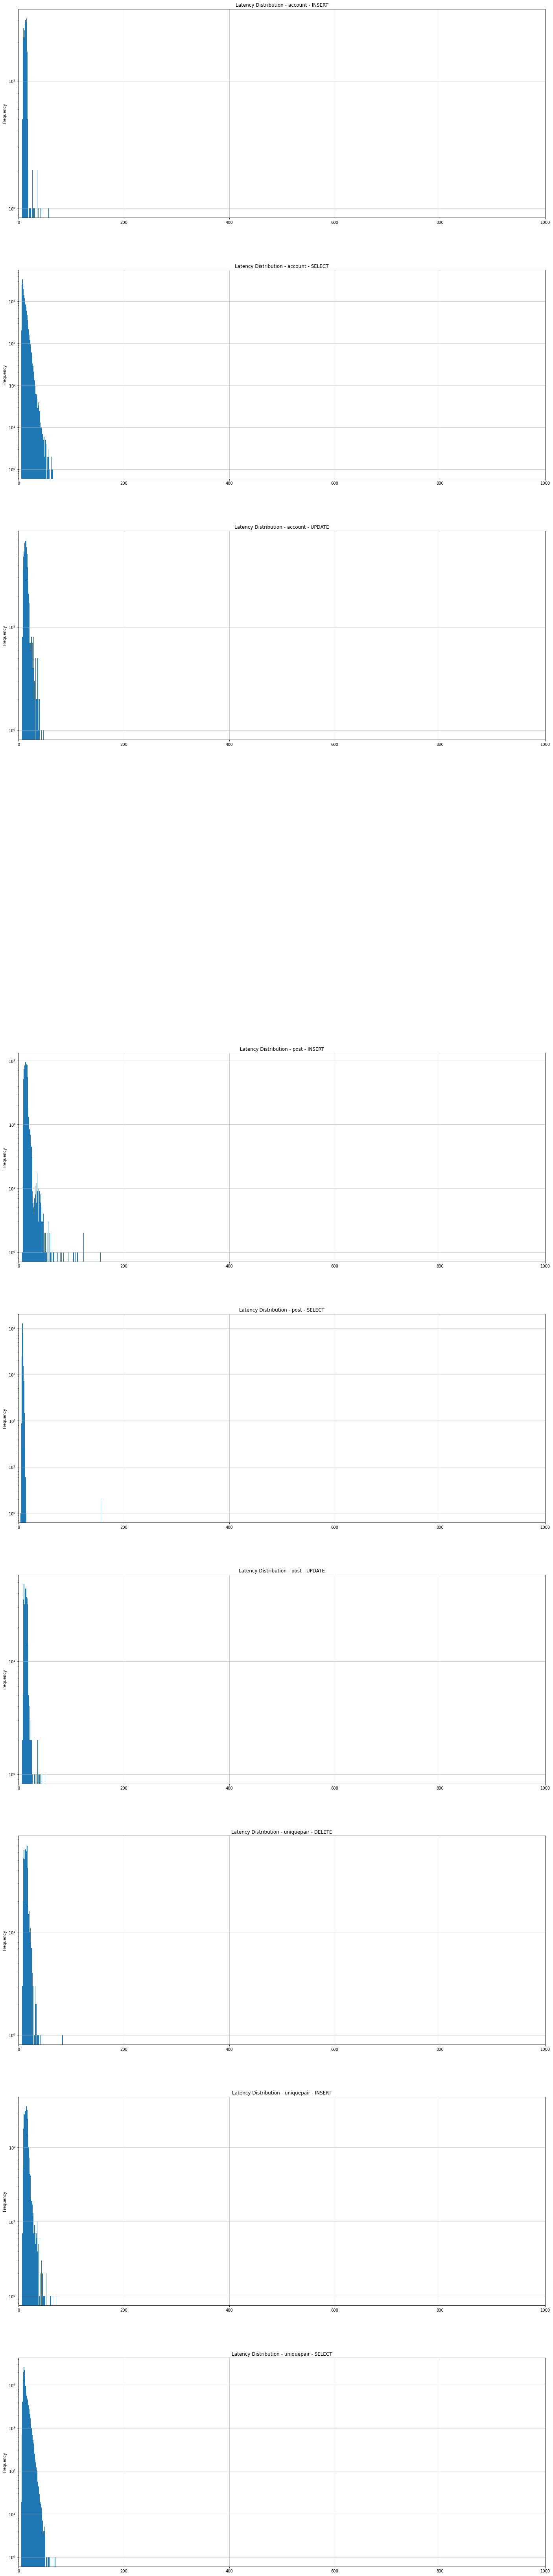

In [9]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot
fig = plt.figure(figsize=(24, len(dbnames) * len(types) * 12))
for (i, dbname) in enumerate(dbnames):
    for (j, type) in enumerate(types):
        df = query[(query["dbname"] == dbname) & (query["type"] == type)]
        if MIN_TIME:
            df = df[(df.index >= MIN_TIME)]
        if MAX_TIME:
            df = df[(df.index <= MAX_TIME)]
        if df.empty:
            continue
        df["latency_bin"] = df.apply(lambda r: int(r["latency"] // LATENCY_BIN_IN_MS), axis=1)
        ax = fig.add_subplot(len(dbnames) * len(types), 1, i * len(types) + j + 1)
        ax.set_yscale("log")
        ax.grid(alpha=0.75)
        ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
        df["latency_bin"].plot(ax=ax, kind="hist", title="Latency Distribution - %s - %s" % (dbname, type),
            xlabel="Latency (milliseconds)", ylabel="Queries (count)",
            bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)
        plt.subplots_adjust(hspace=0.25)

## Statistics

In [10]:
for (i, dbname) in enumerate(dbnames):
    print(dbname)
    for (j, type) in enumerate(types):
        df = query[(query["dbname"] == dbname) & (query["type"] == type)]
        if df.empty:
            continue
        print("  %s" % type)
        print("    Number of queries")
        print("      Total:       %7d" % df.shape[0])
        print("      Avg:         %7.2f" % (df.shape[0] / (df.index.max() - df.index.min())))
        print("    Latency (ms)")
        print("    P99.9:         %7.2f" % (df["latency"].quantile(0.999)))
        print("      P99:         %7.2f" % (df["latency"].quantile(0.99)))
        print("      P95:         %7.2f" % (df["latency"].quantile(0.95)))
        print("      P50:         %7.2f" % (df["latency"].quantile(0.50)))
        print("      Avg:         %7.2f" % (df["latency"].mean()))
        print("      Std:         %7.2f" % (df["latency"].std()))

account
  INSERT
    Number of queries
      Total:           256
      Avg:            3.63
    Latency (ms)
    P99.9:           53.76
      P99:           36.44
      P95:           21.75
      P50:           13.04
      Avg:           13.72
      Std:            5.49
  SELECT
    Number of queries
      Total:        184917
      Avg:          258.28
    Latency (ms)
    P99.9:           37.73
      P99:           25.59
      P95:           19.09
      P50:            9.26
      Avg:           10.67
      Std:            4.35
  UPDATE
    Number of queries
      Total:           702
      Avg:            1.00
    Latency (ms)
    P99.9:           44.45
      P99:           36.94
      P95:           28.06
      P50:           14.08
      Avg:           15.35
      Std:            5.93
post
  INSERT
    Number of queries
      Total:          8040
      Avg:           11.32
    Latency (ms)
    P99.9:           84.87
      P99:           39.19
      P95:           21.77
      P50:  